<a href="https://colab.research.google.com/github/timmy6602066/group5/blob/main/Dict/sas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers datasets
!pip install transformers[torch] accelerate -U
!pip install rouge_score
!pip install bert_score
!pip install summac
!pip install textstat
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 96.7 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.2
    Uninstalling tokenizers-0.15.2:
      Successfully uninstalled tokenizers-0.15.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
summac 0.0.4 requires huggingface-hub<=0.17.0, but you have huggingface-hub 0.23.4 which is incompatible.


In [ ]:
import os, json, sys
import json
import pandas as pd
import numpy as np
import tensorflow as tf
from datasets import Dataset
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###DATA PREPROCESSING

In [ ]:
TRAIN_SIZE = 10000
VAL_SIZE = 1000
TEST_SIZE = 1000

In [ ]:
# Load the dataset
train_json_path = '/content/drive/MyDrive/Biolay/Data sets/Elife/train.json'
with open(train_json_path, 'r') as file:
    train_data = json.load(file)

In [ ]:
# Load the dataset
val_json_path = '/content/drive/MyDrive/Biolay/Data sets/Elife/val.json'
with open(val_json_path, 'r') as file:
    val_data = json.load(file)

In [ ]:
# Load the dataset
test_json_path = '/content/drive/MyDrive/Biolay/Data sets/Elife/test.json'
with open(test_json_path, 'r') as file:
    test_data = json.load(file)

In [ ]:
# Extract abstracts
train_abstract_list = []
train_summary_list = []
for article in train_data[:TRAIN_SIZE]:
    abstract_list = article['abstract']
    abstract = ' '.join(abstract_list)
    train_abstract_list.append(abstract)
    summary_list = article['summary']
    summary = ' '.join(summary_list)
    train_summary_list.append(summary)

In [ ]:
# Extract abstracts
val_abstract_list = []
val_summary_list = []
for article in val_data[:VAL_SIZE]:
    abstract_list = article['abstract']
    abstract = ' '.join(abstract_list)
    val_abstract_list.append(abstract)
    summary_list = article['summary']
    summary = ' '.join(summary_list)
    val_summary_list.append(summary)

In [ ]:
# Extract abstracts
test_abstract_list = []
test_summary_list = []
for article in test_data[:TEST_SIZE]:
    abstract_list = article['abstract']
    abstract = ' '.join(abstract_list)
    test_abstract_list.append(abstract)
    summary_list = article['summary']
    summary = ' '.join(summary_list)
    test_summary_list.append(summary)

In [ ]:
# Create a DataFrame
train_df = pd.DataFrame(
    {'abstract': train_abstract_list, 'summary': train_summary_list})
val_df = pd.DataFrame(
    {'abstract': val_abstract_list, 'summary': val_summary_list})
test_df = pd.DataFrame(
    {'abstract': test_abstract_list, 'summary': test_summary_list})

In [ ]:
# Convert DataFrame to Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

In [ ]:
print(f'Training set size: {len(train_abstract_list)}')
print(f'Validation set size: {len(val_abstract_list)}')
print(f'Test set size: {len(test_abstract_list)}')

Training set size: 4346
Validation set size: 241
Test set size: 241


In [ ]:
print(train_dataset[0])
print(val_dataset[0])
print(test_dataset[0])


{'abstract': 'In temperate climates , winter deaths exceed summer ones . However , there is limited information on the timing and the relative magnitudes of maximum and minimum mortality , by local climate , age group , sex and medical cause of death . We used geo-coded mortality data and wavelets to analyse the seasonality of mortality by age group and sex from 1980 to 2016 in the USA and its subnational climatic regions . Death rates in men and women ≥ 45 years peaked in December to February and were lowest in June to August , driven by cardiorespiratory diseases and injuries . In these ages , percent difference in death rates between peak and minimum months did not vary across climate regions , nor changed from 1980 to 2016 . Under five years , seasonality of all-cause mortality largely disappeared after the 1990s . In adolescents and young adults , especially in males , death rates peaked in June/July and were lowest in December/January , driven by injury deaths .', 'summary': 'In 

##Loading the pretrained model

In [ ]:
# Load the model and tokenizer
model_name = "haining/scientific_abstract_simplification"
tokenizer = AutoTokenizer.from_pretrained(
    "haining/scientific_abstract_simplification")
model = AutoModelForSeq2SeqLM.from_pretrained(
    "haining/scientific_abstract_simplification")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/787 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

In [ ]:
def count_tokens(texts_list):
  tokenized_list = [len(tokenizer(
      text, padding=False, return_tensors='pt',
      truncation=False)['input_ids'][0]) for text in texts_list]
  print(tokenized_list)
  avg_tokens = np.mean(tokenized_list)
  max_tokens = np.max(tokenized_list)
  min_tokens = np.min(tokenized_list)
  return [avg_tokens, max_tokens, min_tokens]

train_tokens_counts = count_tokens(train_abstract_list)
val_tokens_counts = count_tokens(val_abstract_list)
test_tokens_counts = count_tokens(test_abstract_list)

token_counts_df = pd.DataFrame({
    "Average Tokens": [train_tokens_counts[0], val_tokens_counts[0], test_tokens_counts[0]],
    "Max Tokens": [train_tokens_counts[1], val_tokens_counts[1], test_tokens_counts[1]],
    "Min Tokens": [train_tokens_counts[2], val_tokens_counts[2], test_tokens_counts[2]]
})

print(token_counts_df)

[227, 258, 373, 222, 228, 266, 243, 262, 319, 257, 273, 298, 267, 252, 197, 216, 306, 265, 241, 226, 230, 284, 295, 233, 327, 230, 292, 286, 267, 240, 216, 233, 284, 292, 172, 275, 328, 248, 254, 277, 364, 231, 296, 324, 248, 234, 292, 236, 353, 304, 261, 290, 254, 246, 361, 231, 296, 234, 286, 262, 285, 243, 295, 241, 271, 308, 398, 299, 269, 324, 319, 297, 301, 322, 253, 343, 203, 263, 269, 291, 301, 272, 320, 307, 296, 223, 250, 232, 246, 284, 392, 227, 303, 288, 248, 257, 322, 367, 272, 254, 244, 249, 219, 226, 229, 360, 289, 255, 275, 245, 256, 238, 259, 285, 268, 321, 150, 262, 263, 361, 195, 266, 293, 292, 254, 255, 299, 245, 334, 254, 234, 263, 313, 222, 273, 259, 237, 218, 302, 283, 214, 229, 289, 310, 334, 214, 279, 286, 248, 288, 232, 261, 309, 291, 290, 252, 250, 310, 285, 311, 289, 228, 294, 321, 260, 308, 286, 220, 339, 224, 340, 198, 318, 230, 290, 247, 357, 305, 283, 258, 323, 286, 271, 278, 242, 259, 273, 251, 308, 269, 349, 289, 308, 221, 237, 274, 304, 299, 274, 322,

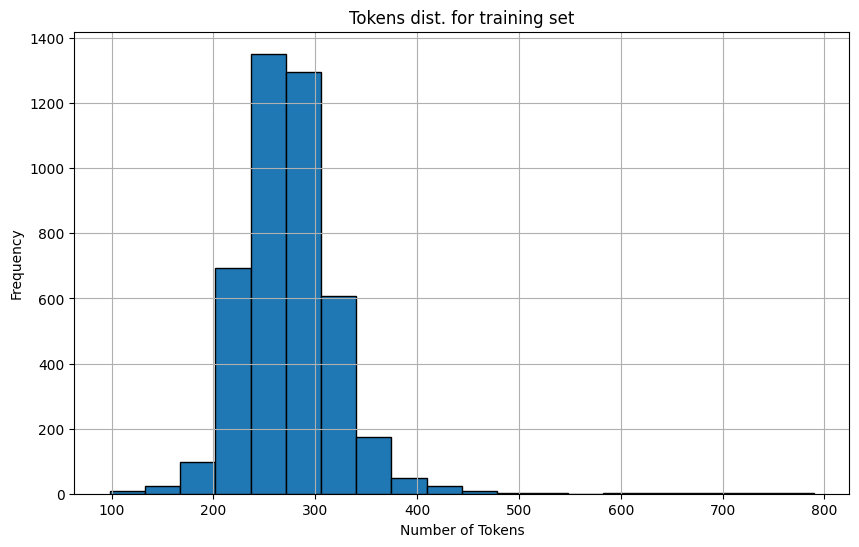

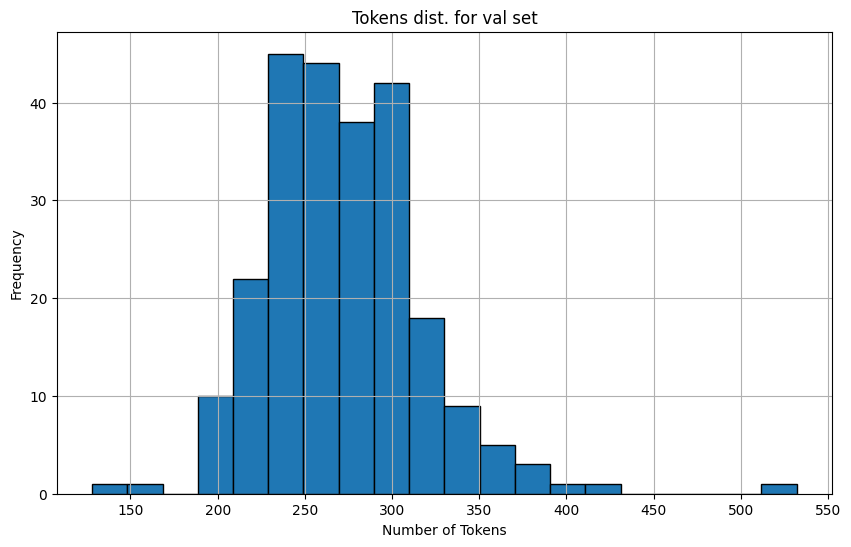

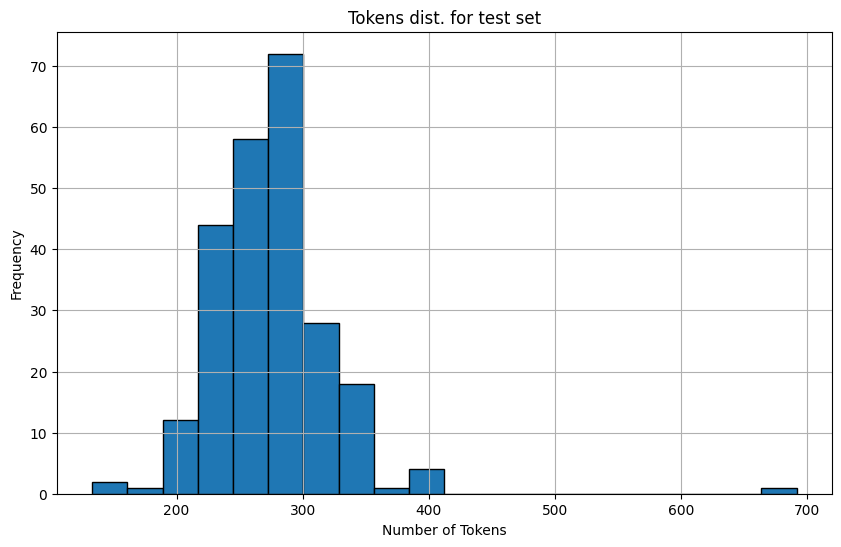

In [ ]:
def plot_token_frequency(texts_list, tokenizer, title):
    # Tokenize the texts and count the number of tokens
    token_lengths = [
        len(tokenizer(
            text, padding=False, return_tensors='pt', truncation=False)[
                'input_ids'][0]) for text in texts_list]

    # Create a DataFrame for plotting
    df = pd.DataFrame(token_lengths, columns=['Token Length'])

    # Plot the frequency distribution
    plt.figure(figsize=(10, 6))
    df['Token Length'].plot(kind='hist', bins=20, edgecolor='black')
    plt.title(title)
    plt.xlabel('Number of Tokens')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Plot the frequency distribution for each text list
plot_token_frequency(
    train_abstract_list, tokenizer, "Tokens dist. for training set")
plot_token_frequency(val_abstract_list, tokenizer, "Tokens dist. for val set")
plot_token_frequency(test_abstract_list, tokenizer, "Tokens dist. for test set")

In [ ]:
# Preprocess the data
def preprocess_data(examples):
    inputs = [abstract for abstract in examples['abstract']]
    model_inputs = tokenizer(
        inputs, max_length=512, truncation=True, padding="max_length",
        return_tensors='pt')

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples['summary'], max_length=512, truncation=True,
            padding="max_length", return_tensors='pt')

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Preprocess the datasets
train_dataset_prep = train_dataset.map(preprocess_data, batched=True)
val_dataset_prep = val_dataset.map(preprocess_data, batched=True)
test_dataset_prep = test_dataset.map(preprocess_data, batched=True)

Map:   0%|          | 0/4346 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3856: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/241 [00:00<?, ? examples/s]

Map:   0%|          | 0/241 [00:00<?, ? examples/s]

In [ ]:
len(train_data)

4346

In [ ]:
def generate_summary(abstract):
    inputs = tokenizer(
        abstract, return_tensors="pt", max_length=600, padding='max_length',
        truncation=True)
    input_ids = inputs["input_ids"]

    # Generate summary
    outputs = model.generate(
        input_ids, max_length=512, min_length=300, num_beams=4, temperature=0.4,
        early_stopping=True, do_sample=True)

    summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return summary

In [ ]:
generate_summary(test_abstract_list[0])

'Most movements are not unitary, but are composed of sequences. People with cerebellar pathology have severe problems with sequencing. Eyelid conditioning is a cerebellar-mediated behavior that provides the ability to control and restrict inputs to the cerebellum through stimulation of mossy fibers. We used this ability to directly how the cerebellum can learn a sequence of inter-connected movement components in rabbits. We show that the feedback signals from one component are sufficient to serve as a cue for the next component in the sequence. In vivo recordings from Purkinje cells demonstrated that all components of the sequence were encoded similarly by cerebellar cortex. These results provide a simple yet general framework for how the cerebellum can use simple associate learning processes to chain together a sequence of appropriately timed responses.                                                           '

###Training

In [ ]:
# Set training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
)

NameError: name 'Seq2SeqTrainingArguments' is not defined

In [ ]:
# Initialize the Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_prep,
    eval_dataset=val_dataset_prep,
    tokenizer=tokenizer,
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,2.153000,1.985127
2,2.053800,1.943585
3,2.018300,1.934009


TrainOutput(global_step=3261, training_loss=2.1171551013936005, metrics={'train_runtime': 3363.6676, 'train_samples_per_second': 3.876, 'train_steps_per_second': 0.969, 'total_flos': 3.52143334490112e+16, 'train_loss': 2.1171551013936005, 'epoch': 3.0})

In [ ]:
# Save the fine-tuned model
model.save_pretrained("./drive/MyDrive/Biolay/Data sets/Elife/fine-tuned-model1")
tokenizer.save_pretrained("./drive/MyDrive/Biolay/Data sets/Elife/fine-tuned-model1")

('./drive/MyDrive/Biolay/Data sets/Elife/fine-tuned-model1/tokenizer_config.json',
 './drive/MyDrive/Biolay/Data sets/Elife/fine-tuned-model1/special_tokens_map.json',
 './drive/MyDrive/Biolay/Data sets/Elife/fine-tuned-model1/tokenizer.json')

In [ ]:
# # Load the fine-tuned model and tokenizer
# fine_tuned_model_path = "./drive/MyDrive/Biolay/Data sets/Elife/fine-tuned-model1"
# fine_tuned_tokenizer_path = "./drive/MyDrive/Biolay/Data sets/Elife/fine-tuned-model1"

# pipe = pipeline(
#     "text2text-generation", model=fine_tuned_model_path,
#     tokenizer=fine_tuned_tokenizer_path)

# # Example usage
# abstract = """
# Cell-fate reprograming is at the heart of development, yet very little is known
# about the molecular mechanisms promoting or inhibiting reprograming in intact
# organisms. In the C. elegans germline, reprograming germ cells into somatic
# cells requires chromatin perturbation. Here, we describe that such reprograming
# is facilitated by GLP-1/Notch signaling pathway. This is surprising, since this
# pathway is best known for maintaining undifferentiated germline stem
# cells/progenitors. Through a combination of genetics, tissue-specific
# transcriptome analysis, and functional studies of candidate genes, we uncovered
# a possible explanation for this unexpected role of GLP-1/Notch. We propose that
# GLP-1/Notch promotes reprograming by activating specific genes, silenced by the
# Polycomb repressive complex 2 (PRC2), and identify the conserved histone
# demethylase UTX-1 as a crucial GLP-1/Notch target facilitating reprograming.
# These findings have wide implications, ranging from development to diseases
# associated with abnormal Notch signaling.
# """

# output = pipe(abstract, max_length=512, min_length=200, do_sample=False)
# print(output)
# print("Summary:", output[0]['generated_text'])


[{'generated_text': 'Cell-fate reproduction is essential for all organisms, from humans to insects. In the nematode C. elegans, the germline is the first cell to divide, and it is essential for the development of new tissues and organs. However, it is not fully understood how the germline is reprogrammed to become different cell types. Here, we show that a signaling pathway called GLP-1/Notch promotes the reprogramming of germline cells into somatic cells. This pathway is best known for maintaining undifferentiated stem cells/progenitors in the germline, but it is not known how it promotes the reprogramming of germline cells into somatic cells. Here, we identify a protein called UTX-1 as a crucial target of GLP-1/Notch and show that it is essential for the reprogramming of germline cells into somatic cells. These findings have wide implications, ranging from diseases associated with abnormal Notch signaling to diseases associated with mutations in the Notch signaling pathway.'}]
Summar

###Evaluation

In [ ]:
import os, sys, json
import textstat
import numpy as np
from rouge_score import rouge_scorer
from bert_score import score
import nltk
from alignscore import AlignScore
from lens.lens_score import LENS
from summac.model_summac import SummaCConv
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import torch

In [ ]:
# Load the fine-tuned model and tokenizer from Google Drive
model_path_tuned = "./drive/MyDrive/Biolay/Data sets/Elife/fine-tuned-model1/"
tokenizer = AutoTokenizer.from_pretrained("haining/scientific_abstract_simplification")
# tokenizer = AutoTokenizer.from_pretrained(model_path)
model_tuned = AutoModelForSeq2SeqLM.from_pretrained(model_path_tuned).to('cuda')

In [ ]:
def calc_rouge(preds, refs):
  # Get ROUGE F1 scores
  scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeLsum'], \
                                    use_stemmer=True, split_summaries=True)
  scores = [scorer.score(p, refs[i]) for i, p in enumerate(preds)]
  return np.mean([s['rouge1'].fmeasure for s in scores]), \
         np.mean([s['rouge2'].fmeasure for s in scores]), \
         np.mean([s['rougeLsum'].fmeasure for s in scores])

def calc_bertscore(preds, refs):
  # Get BERTScore F1 scores
  P, R, F1 = score(preds, refs, lang="en", verbose=True, device='cuda:0')
  return np.mean(F1.tolist())

def calc_readability(preds):
  fkgl_scores = []
  cli_scores = []
  dcrs_scores = []
  for pred in preds:
    fkgl_scores.append(textstat.flesch_kincaid_grade(pred))
    cli_scores.append(textstat.coleman_liau_index(pred))
    dcrs_scores.append(textstat.dale_chall_readability_score(pred))
  return np.mean(fkgl_scores), np.mean(cli_scores), np.mean(dcrs_scores)

def calc_lens(preds, refs, docs):
  model_path = "./drive/MyDrive/Biolay/evauation_scripts/models/LENS/LENS/checkpoints/epoch=5-step=6102.ckpt"
  metric = LENS(model_path, rescale=True)
  abstracts = [d.split("\n")[0] for d in docs]
  refs = [[x] for x in refs]

  scores = metric.score(abstracts, preds, refs, batch_size=8, gpus=1)
  return np.mean(scores)

def calc_alignscore(preds, docs):
  alignscorer = AlignScore(
      model='roberta-base', batch_size=16, device='cuda:0',
      ckpt_path='./drive/MyDrive/Biolay/evauation_scripts/models/AlignScore/AlignScore-base.ckpt',
      evaluation_mode='nli_sp')
  return np.mean(alignscorer.score(contexts=docs, claims=preds))

def cal_summac(preds, docs):
  model_conv = SummaCConv(models=["vitc"], bins='percentile', granularity="sentence", nli_labels="e", device="cuda", start_file="default", agg="mean")
  return np.mean(model_conv.score(docs, preds)['scores'])

def read_file_lines(path):
  with open(path, 'r') as f:
    lines = f.readlines()

  if path.endswith('.jsonl'):
    lines = [json.loads(line) for line in lines]

  return lines

In [ ]:
def generate_predictions(abstracts, model, tokenizer, output_path):
    INSTRUCTION = "summarize, simplify, and contextualize: "
    preds = []
    for abstract in abstracts:
        inputs = tokenizer(
            INSTRUCTION + abstract, return_tensors='pt', truncation=True,
            padding=True, max_length=512).to('cuda')
        summary_ids = model.generate(
            inputs['input_ids'], attention_mask=inputs['attention_mask'],
            max_length=512, min_length=300, num_beams=4, temperature=0.4,
            early_stopping=True, do_sample=True)
        preds.append(tokenizer.decode(summary_ids[0], skip_special_tokens=True))

    # Save predictions to a file
    with open(output_path, 'w') as f:
        for pred in preds:
            f.write(pred + '\n')

    return preds


In [ ]:
def evaluate(refs, docs, model, tokenizer):
  # Load data from files
  preds = generate_predictions(
      docs, model_tuned, tokenizer,
      './drive/MyDrive/Biolay/Data sets/Elife/results/preds.txt')

  score_dict = {}

  # Relevance scores
  rouge1_score, rouge2_score, rougel_score = calc_rouge(preds, refs)
  score_dict['ROUGE1'] = rouge1_score
  score_dict['ROUGE2'] = rouge2_score
  score_dict['ROUGEL'] = rougel_score
  score_dict['BERTScore'] = calc_bertscore(preds, refs)

  # # Readability scores
  fkgl_score, cli_score, dcrs_score = calc_readability(preds)
  score_dict['FKGL'] = fkgl_score
  score_dict['DCRS'] = dcrs_score
  score_dict['CLI'] = cli_score
  score_dict['LENS'] = calc_lens(preds, refs, docs)

  # Factuality scores
  score_dict['AlignScore'] = calc_alignscore(preds, docs)
  score_dict['SummaC'] = cal_summac(preds, docs)

  return score_dict

In [ ]:
def write_scores(score_dict, output_filepath):
  # Write scores to file
  with open(output_filepath, 'w') as f:
    for key, value in score_dict.items():
      f.write(f"{key}: {value}\n")

In [ ]:
output_dir = "./drive/MyDrive/Biolay/Data sets/Elife/results/scores"
elife_scores = evaluate(
    test_summary_list[0:2], test_abstract_list[0:2], model_tuned, tokenizer)
write_scores(elife_scores, os.path.join(output_dir, 'elife_scores.txt'))

torch.cuda.empty_cache()

UnicodeEncodeError: 'ascii' codec can't encode character '\u2019' in position 96: ordinal not in range(128)

In [ ]:
output_dir = "./drive/MyDrive/Biolay/Data sets/Elife/results/scores"
elife_scores_base = evaluate(
    test_summary_list[0:2], test_abstract_list[0:2], model.to('cuda'), tokenizer)
write_scores(elife_scores, os.path.join(output_dir, 'elife_scores_base.txt'))

torch.cuda.empty_cache()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.17 seconds, 11.85 sentences/sec


TypeError: pytorch_lightning.core.module.LightningModule.load_from_checkpoint() got multiple values for keyword argument 'strict'

###NOTES

In [ ]:
predictions = generate_predictions(
      test_abstract_list[0:2], model_tuned, tokenizer,
      './drive/MyDrive/Biolay/Data sets/Elife/results/preds.txt')

UnicodeEncodeError: 'ascii' codec can't encode character '\u2019' in position 96: ordinal not in range(128)

In [ ]:
test_abstract_list[0]

'Most movements are not unitary , but are comprised of sequences . Although patients with cerebellar pathology display severe deficits in the execution and learning of sequences ( Doyon et al . , 1997; Shin and Ivry , 2003 ) , most of our understanding of cerebellar mechanisms has come from analyses of single component movements . Eyelid conditioning is a cerebellar-mediated behavior that provides the ability to control and restrict inputs to the cerebellum through stimulation of mossy fibers . We utilized this advantage to test directly how the cerebellum can learn a sequence of inter-connected movement components in rabbits . We show that the feedback signals from one component are sufficient to serve as a cue for the next component in the sequence . In vivo recordings from Purkinje cells demonstrated that all components of the sequence were encoded similarly by cerebellar cortex . These results provide a simple yet general framework for how the cerebellum can use simple associate le

In [ ]:
prediction_base = generate_predictions(
      test_abstract_list[0:2], model.to('cuda'), tokenizer,
      './drive/MyDrive/Biolay/Data sets/Elife/results/preds.txt')

In [ ]:
output_dir = "./drive/MyDrive/Biolay/Data sets/Elife/results/scores"
elife_scores_base = evaluate(
    test_summary_list[0:2], test_abstract_list[0:2], model.to('cuda'), tokenizer)
write_scores(elife_scores, os.path.join(output_dir, 'elife_scores_base.txt'))

torch.cuda.empty_cache()